In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install pydlm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 635.4 kB/s eta 0:00:00


In [3]:
# 1. Các thư viện cần thiết
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from pydlm import dlm, trend, dynamic
import matplotlib.pyplot as plt
from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason

In [34]:
#import dataset
df = pd.read_csv('/content/drive/MyDrive/PTTK/MBB.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')  # Use the correct format
df.set_index('Date', inplace=True)
df = df.dropna()
df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2016-01-05,4894.0,4894.0,4964.0,4894.0,1.07M,0.0
2016-01-06,4929.0,4894.0,4929.0,4894.0,670.50K,0.0
2016-01-07,4859.0,4929.0,4929.0,4859.0,1.61M,0.0
2016-01-08,4824.0,4824.0,4859.0,4789.0,1.73M,0.0
2016-01-11,4789.0,4824.0,4859.0,4789.0,1.12M,0.0
...,...,...,...,...,...,...
2023-12-21,18150.0,18100.0,18150.0,18000.0,3.98M,0.0
2023-12-22,18300.0,18150.0,18450.0,18100.0,8.55M,0.0
2023-12-25,18400.0,18350.0,18550.0,18300.0,6.59M,0.0


In [6]:
#RATIO 7:3

In [35]:
# split data ratio 7:3
train_size73 = int(0.7 * len(df))
test_size73 = int(0.3 * len(df))

train_data73 = df[:train_size73]
test_data73 = df[train_size73:train_size73+test_size73]

In [36]:
import statsmodels.api as sm
acf = sm.tsa.stattools.acf(train_data73['Price'], nlags= 700)

In [37]:
# training 7:3
y_train73 = np.array(train_data73['Price'])

x_train73 = []
for data in train_data73['High']:
  x_train73.append([data])

model73 = dlm(y_train73)
model73 = model73 + trend(1, discount=0.99, name='Trend', w=1e7)
model73 = model73 + dynamic(features=x_train73, discount=1, name='High')
model73 = model73 + autoReg(degree=3, discount=0.99, name='ar', w=1e7)
model73 = model73 + longSeason(period=12, stay=30, data=y_train73, name='season', w=1e7)

model73.fit()

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


In [38]:
# testing 7:3
x_test73 = []
for data in test_data73['High']:
  x_test73.append([data])

y_test73 = np.array(test_data73['Price'])

y_pred73 = model73.predictN(date = model73.n-1, N=len(x_test73),featureDict={'High': x_test73})
y_pred73 = y_pred73[0]


In [39]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd

# Assuming train_data73 is a DataFrame with 'Price' column and 'Date' as the index
# Make sure 'Date' is in datetime format
train_data73.index = pd.to_datetime(train_data73.index)

ln_model73 = LinearRegression()

# Use the datetime index for training
ln_model73.fit(np.arange(len(train_data73)).reshape(-1, 1), train_data73['High'])

# Predict the prices for the next 30 days
last_index73 = train_data73.index[-1]
next_30_days_indices73 = np.arange(len(train_data73), len(train_data73) + 30).reshape(-1, 1)

# Use the model to predict the high prices for the next 30 days
high_next_30_days73 = ln_model73.predict(next_30_days_indices73)

# Generate the next 30 days date indices
next_30_days_dates73 = pd.date_range(start=last_index73 + pd.DateOffset(1), periods=30)

# Combine the predicted dates and prices into a DataFrame
predicted_df73 = pd.DataFrame({'Date': next_30_days_dates73, 'Predicted_High': high_next_30_days73})
predicted_df73.set_index('Date', inplace=True)

print(predicted_df73)


            Predicted_High
Date                      
2021-08-07    16332.446880
2021-08-08    16340.959418
2021-08-09    16349.471956
2021-08-10    16357.984495
2021-08-11    16366.497033
2021-08-12    16375.009572
2021-08-13    16383.522110
2021-08-14    16392.034648
2021-08-15    16400.547187
2021-08-16    16409.059725
2021-08-17    16417.572264
2021-08-18    16426.084802
2021-08-19    16434.597340
2021-08-20    16443.109879
2021-08-21    16451.622417
2021-08-22    16460.134956
2021-08-23    16468.647494
2021-08-24    16477.160033
2021-08-25    16485.672571
2021-08-26    16494.185109
2021-08-27    16502.697648
2021-08-28    16511.210186
2021-08-29    16519.722725
2021-08-30    16528.235263
2021-08-31    16536.747801
2021-09-01    16545.260340
2021-09-02    16553.772878
2021-09-03    16562.285417
2021-09-04    16570.797955
2021-09-05    16579.310493


In [40]:
# Dự báo giá cổ phiếu 30 ngày tiếp theo 7:3
x_next_30_days73 = []
for data in high_next_30_days73:
  x_next_30_days73.append([data])

y_next_30_days73 = model73.predictN(N = 30, featureDict={'High': x_next_30_days73})
y_next_30_days73 = y_next_30_days73[0]
print(y_next_30_days73)


[24738.291863926774, 24742.698792652624, 24746.67362645478, 24763.264908426616, 24778.54451461983, 24794.746330516136, 24811.411580860327, 24828.081531191616, 24844.827144152576, 24861.593301381577, 24878.36506186289, 24895.141694902923, 24911.91962262286, 23654.297304673393, 23682.55354231573, 23605.302566885577, 23566.35823023917, 23577.22594253877, 23585.714879608266, 23599.62235739915, 23615.549915208885, 23631.751468125403, 23648.34356202085, 23665.043344242982, 23681.783284872214, 23698.54839592612, 23715.321091792146, 23732.09738374448, 23748.87533634276, 23765.653880747177]


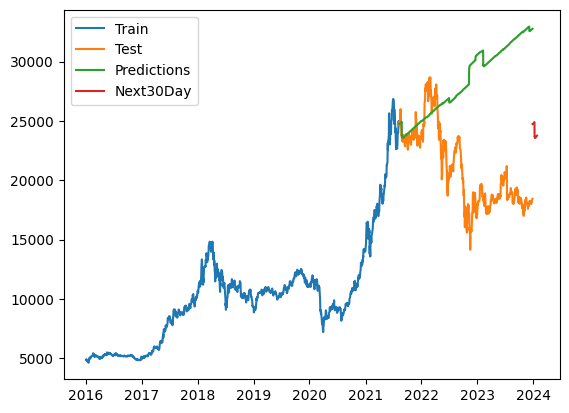

In [41]:
# Generating the next 30 days date indices
last_test_date73 = test_data73.index[-1]
next_30_days_dates73 = pd.date_range(start=last_test_date73 + pd.DateOffset(1), periods=30)

# 10. Vẽ hình 7:3
plt.plot(train_data73.index, train_data73['Price'])
plt.plot(test_data73.index, test_data73['Price'])
plt.plot(test_data73.index, y_pred73)
plt.plot(next_30_days_dates73,y_next_30_days73)
plt.legend(['Train', 'Test', 'Predictions','Next30Day'])
plt.show()

In [13]:
#RATIO 8:2

In [42]:
# Split the data into training, testing, and validating sets
train_size82 = int(0.8 * len(df))
test_size82 = int(0.2 * len(df))

train_data82 = df[:train_size82]
test_data82 = df[train_size82:train_size82+test_size82]

In [43]:
import statsmodels.api as sm
acf = sm.tsa.stattools.acf(train_data82['Price'], nlags= 700)

In [44]:
# training
y_train82 = np.array(train_data82['Price'])

x_train82 = []
for data in train_data82['High']:
  x_train82.append([data])

model82 = dlm(y_train82)
model82 = model82 + trend(1, discount=0.99, name='Trend', w=1e7)
model82 = model82 + dynamic(features=x_train82, discount=1, name='High')
model82 = model82 + autoReg(degree=3, discount=0.99, name='ar', w=1e7)
model82 = model82 + longSeason(period=12, stay=30, data=y_train82, name='season', w=1e7)

model82.fit()

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


In [45]:
# testing
x_test82= []
for data in test_data82['High']:
  x_test82.append([data])

y_test82 = np.array(test_data82['High'])

y_pred82 = model82.predictN(date = model82.n-1, N=len(x_test82),featureDict={'High': x_test82})
y_pred82 = y_pred82[0]


In [46]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd

# Make sure 'Date' is in datetime format
train_data82.index = pd.to_datetime(train_data82.index)

ln_model82 = LinearRegression()

# Use the datetime index for training
ln_model82.fit(np.arange(len(train_data82)).reshape(-1, 1), train_data82['High'])

# Predict the prices for the next 30 days
last_index82 = train_data82.index[-1]
next_30_days_indices82 = np.arange(len(train_data82), len(train_data82) + 30).reshape(-1, 1)

# Use the model to predict the high prices for the next 30 days
high_next_30_days82 = ln_model82.predict(next_30_days_indices82)

# Generate the next 30 days date indices
next_30_days_dates82 = pd.date_range(start=last_index82 + pd.DateOffset(1), periods=30)

# Combine the predicted dates and prices into a DataFrame
predicted_df82 = pd.DataFrame({'Date': next_30_days_dates82, 'Predicted_High': high_next_30_days82})
predicted_df82.set_index('Date', inplace=True)

print(predicted_df82)


            Predicted_High
Date                      
2022-05-28    21595.460309
2022-05-29    21607.211849
2022-05-30    21618.963388
2022-05-31    21630.714928
2022-06-01    21642.466468
2022-06-02    21654.218007
2022-06-03    21665.969547
2022-06-04    21677.721087
2022-06-05    21689.472626
2022-06-06    21701.224166
2022-06-07    21712.975706
2022-06-08    21724.727245
2022-06-09    21736.478785
2022-06-10    21748.230325
2022-06-11    21759.981864
2022-06-12    21771.733404
2022-06-13    21783.484944
2022-06-14    21795.236483
2022-06-15    21806.988023
2022-06-16    21818.739563
2022-06-17    21830.491102
2022-06-18    21842.242642
2022-06-19    21853.994182
2022-06-20    21865.745721
2022-06-21    21877.497261
2022-06-22    21889.248801
2022-06-23    21901.000340
2022-06-24    21912.751880
2022-06-25    21924.503420
2022-06-26    21936.254959


In [47]:
# Dự báo giá cổ phiếu 30 ngày tiếp theo
x_next_30_days82 = []
for data in high_next_30_days82:
  x_next_30_days82.append([data])

y_next_30_days82 = model82.predictN(N = 30, featureDict={'High': x_next_30_days82})
y_next_30_days82 = y_next_30_days82[0]
print(y_next_30_days82)


[23473.9871119695, 23425.521122013077, 23423.641597921927, 23455.076335506128, 23470.5010254852, 23480.503417415053, 23494.891691750207, 23509.879173920275, 23523.782567066133, 23537.704509152205, 23551.870193673923, 23565.996788199, 23580.07355903242, 23594.1663418478, 23608.268161266344, 23622.365048096326, 23636.460586033394, 23650.55743825421, 23664.654409156523, 23678.751064298573, 23692.847737620712, 23706.94448012686, 23721.041208605104, 23735.13792336153, 22556.52250544102, 22488.78709683852, 22732.316245050308, 22720.897101219714, 22684.091975232175, 22710.763176848966]


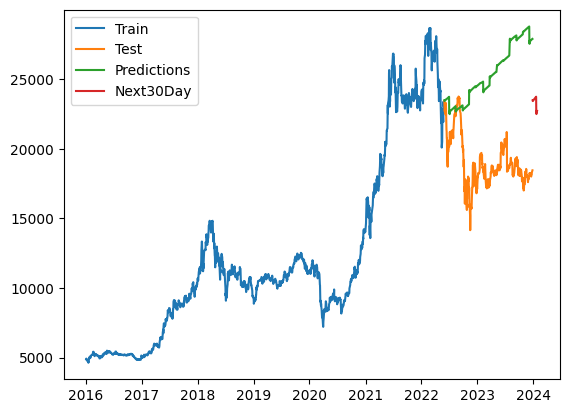

In [48]:
# Generating the next 30 days date indices
last_test_date82 = test_data82.index[-1]
next_30_days_dates82 = pd.date_range(start=last_test_date82 + pd.DateOffset(1), periods=30)
# 10. Vẽ hình
plt.plot(train_data82.index, train_data82['Price'])
plt.plot(test_data82.index, test_data82['Price'])
plt.plot(test_data82.index, y_pred82)
plt.plot(next_30_days_dates82,y_next_30_days82)
plt.legend(['Train', 'Test', 'Predictions','Next30Day'])
plt.show()

In [21]:
#RATIO 9:1

In [49]:
# Split the data into training, testing, and validating sets
train_size91 = int(0.9 * len(df))
test_size91 = int(0.1 * len(df))

train_data91 = df[:train_size91]
test_data91 = df[train_size91:train_size91+test_size91]

In [50]:
import statsmodels.api as sm
acf = sm.tsa.stattools.acf(train_data91['Price'], nlags= 700)

In [51]:
# 4. Quá trình training
y_train91 = np.array(train_data91['Price'])

x_train91 = []
for data in train_data91['High']:
  x_train91.append([data])

model91 = dlm(y_train91)
model91 = model91 + trend(1, discount=0.99, name='Trend', w=1e7)
model91 = model91 + dynamic(features=x_train91, discount=1, name='High')
model91 = model91 + autoReg(degree=3, discount=0.99, name='ar', w=1e7)
model91 = model91 + longSeason(period=12, stay=30, data=y_train91, name='season', w=1e7)

model91.fit()

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


In [52]:
# 5. Quá trình testing
x_test91= []
for data in test_data91['High']:
  x_test91.append([data])

y_test91 = np.array(test_data91['Price'])

y_pred91 = model91.predictN(date = model91.n-1, N=len(x_test91),featureDict={'High': x_test91})
y_pred91 = y_pred91[0]


In [53]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd

# Make sure 'Date' is in datetime format
train_data91.index = pd.to_datetime(train_data91.index)

ln_model91 = LinearRegression()

# Use the datetime index for training
ln_model91.fit(np.arange(len(train_data91)).reshape(-1, 1), train_data91['High'])

# Predict the prices for the next 30 days
last_index91 = train_data91.index[-1]
next_30_days_indices91 = np.arange(len(train_data91), len(train_data91) + 30).reshape(-1, 1)

# Use the model to predict the high prices for the next 30 days
high_next_30_days91 = ln_model91.predict(next_30_days_indices91)

# Generate the next 30 days date indices
next_30_days_dates91 = pd.date_range(start=last_index91 + pd.DateOffset(1), periods=30)

# Combine the predicted dates and prices into a DataFrame
predicted_df91 = pd.DataFrame({'Date': next_30_days_dates91, 'Predicted_High': high_next_30_days91})
predicted_df91.set_index('Date', inplace=True)

print(predicted_df91)


            Predicted_High
Date                      
2023-03-16    22669.958335
2023-03-17    22680.662402
2023-03-18    22691.366469
2023-03-19    22702.070536
2023-03-20    22712.774603
2023-03-21    22723.478670
2023-03-22    22734.182737
2023-03-23    22744.886804
2023-03-24    22755.590871
2023-03-25    22766.294938
2023-03-26    22776.999005
2023-03-27    22787.703072
2023-03-28    22798.407139
2023-03-29    22809.111206
2023-03-30    22819.815273
2023-03-31    22830.519340
2023-04-01    22841.223407
2023-04-02    22851.927474
2023-04-03    22862.631541
2023-04-04    22873.335608
2023-04-05    22884.039675
2023-04-06    22894.743742
2023-04-07    22905.447809
2023-04-08    22916.151876
2023-04-09    22926.855943
2023-04-10    22937.560010
2023-04-11    22948.264077
2023-04-12    22958.968144
2023-04-13    22969.672211
2023-04-14    22980.376278


In [54]:
# 9. Dự báo giá cổ phiếu 30 ngày tiếp theo
x_next_30_days91 = []
for data in high_next_30_days91:
  x_next_30_days91.append([data])

y_next_30_days91 = model91.predictN(N = 30, featureDict={'High': x_next_30_days91})
y_next_30_days91 = y_next_30_days91[0]
print(y_next_30_days91)


[17877.329824414323, 17805.6829999553, 17826.92587365164, 17849.20256884746, 18166.253044882986, 18179.1662852502, 18152.25230128858, 18172.010766656807, 18186.586647169195, 18194.03706021129, 18203.65336863493, 18213.98190456943, 18223.80794695909, 18233.616608433775, 18243.510916916868, 18253.39090414767, 18263.259700235583, 18273.133079912564, 18283.00737781939, 18292.880740444663, 18302.75413946967, 18312.627684577157, 18322.501194508935, 18332.374687519015, 18342.24818968017, 18352.12169278652, 18361.995194203333, 18371.868695802947, 18381.74219764305, 18391.6156994051]


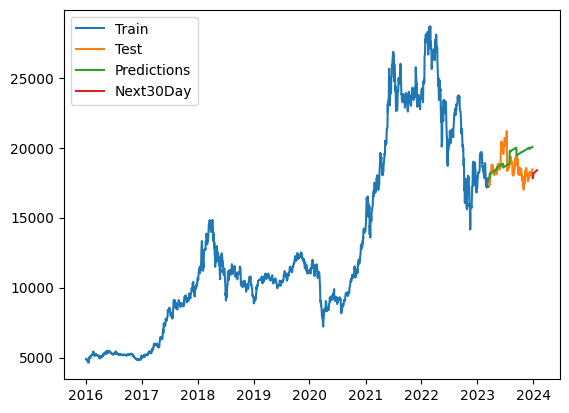

In [55]:
# Generating the next 30 days date indices
last_test_date91 = test_data91.index[-1]
next_30_days_dates91 = pd.date_range(start=last_test_date91 + pd.DateOffset(1), periods=30)
# 10. Vẽ hình
plt.plot(train_data91.index, train_data91['Price'])
plt.plot(test_data91.index, test_data91['Price'])
plt.plot(test_data91.index, y_pred91)
plt.plot(next_30_days_dates91,y_next_30_days91)
plt.legend(['Train', 'Test', 'Predictions','Next30Day'])
plt.show()

In [29]:
#ACCURACY EVALUATION

In [56]:
#method to calculate mape
def calc_mape(actual, predicted):

    # Convert to numpy arrays
    actual = np.array(actual)
    predicted = np.array(predicted)

    # Calculate absolute percentage error
    absolute_error = np.abs((actual - predicted) / actual)

    # Handle division by zero cases
    absolute_error[np.isinf(absolute_error)] = 0.0

    # Calculate mean absolute percentage error
    mape = np.mean(absolute_error) * 100

    return mape

In [57]:
#accuracy evaluate 7:3
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_log_error as msle
test_rmse73 = np.sqrt(np.mean((y_pred73 - y_test73)**2))
test_mape73 = calc_mape(y_test73, y_pred73)
test_msle73 = msle(y_test73, y_pred73)

print(test_rmse73)
print(test_mape73)
print(test_msle73)

9428.530720926388
41.48294512304119
0.15442345039976307


In [58]:
#accuracy evaluate 8:2
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_log_error as msle
test_rmse82 = np.sqrt(np.mean((y_pred82 - y_test82)**2))
test_mape82 = calc_mape(y_test82, y_pred82)
test_msle82 = msle(y_test82, y_pred82)

print(test_rmse82)
print(test_mape82)
print(test_msle82)

6851.00493479045
33.17596129390189
0.09525332658607358


In [59]:
#accuracy evaluate 9:1
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_log_error as msle

test_rmse91 = np.sqrt(np.mean((y_pred91 - y_test91)**2))
test_mape91 = calc_mape(y_test91, y_pred91)
test_msle91 = msle(y_test91, y_pred91)

print(test_rmse91)
print(test_mape91)
print(test_msle91)


1297.30147386767
5.744176887694312
0.0046582954731057245
